In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import analysis.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)



Qubit(RO_LO_pwr=16, ef_ssm=-0.255, RO_LO=6.6247, ef_amp=1, ef_time=76.33212714344363, ge_amp=1.2, ro_dur=4000, qubit_thr=[-10000, -600], IQ_angle=205, ro_freq=6.7275, ROq3=6.583064, ge_ssm=-0.11, qubit_id=q1, ro_amp=0.6, ge_time=51.91894601677215, ROIF=0.10280000000000022)
Qubit(RO_LO_pwr=16, ef_ssm=-0.224, RO_LO=6.6247, ef_amp=1, ef_time=None, ge_amp=1.2, ro_dur=4000, qubit_thr=[-10000, 2500], IQ_angle=85, ro_freq=6.65555, ROq3=6.583064, ge_ssm=-0.152, qubit_id=q2, ro_amp=0.4, ge_time=40.15374412400174, ROIF=0.030850000000000044)


In [3]:
def run_rabi_ef_swap(q1: object, q2: object, general_vals_dict: dict,
                     num_steps: int, sweep_time: float,
                     swap_freq: float, swap_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]
    
    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    
    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified['predicted']
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)
    
    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time/1000, num_steps)
    
    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame({
        'time': times,
        'P_f': probabilties['P_f'],
        'P_e': probabilties['P_e'],
        'P_g': probabilties['P_g']
    }, index=times)

    df_pop = pd.DataFrame({
        'time': times,
        'Pop_f': population['Pop_f'],
        'Pop_e': population['Pop_e'],
        'Pop_g': population['Pop_g']
    }, index=times)
    
    return df_prob,df_pop, values


def sweep_J(J_start: float, J_stop: float, J_steps: int,
                  q1: object, q2: object, general_vals_dict: dict,
                  num_steps: int, sweep_time: float,
                  swap_freq: float, swap_time: float, reps: int):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a 
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.
    
    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as 
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist
    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    # Create an array of frequency values
    J_vals = np.linspace(J_start, J_stop, J_steps)
    
    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals ={}
    git_counter = 0
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J}.pkl")
        values_filename = os.path.join(values_folder, f"j={J}.pkl")
        
        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value
        
        a_to_J = (((2*np.pi)/(2*(2*q1.ef_time*10**-3))))#if J is in units of rad/micros 
        J_to_a = 1/a_to_J
        q1.ef_ssm =-0.25275
        num_steps = 51
        ef_amp=J * J_to_a 
        q1.ef_amp = ef_amp 
        df_prob, df_pop, values = run_rabi_ef_swap(q1, q2, general_vals_dict, num_steps,
                                   sweep_time, swap_freq, swap_time, reps)
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J}.pkl")
        values_filename = os.path.join(values_folder, f"j={J}.pkl")
        
        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
        
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
        # irresponsibly git committing and pushing so I can watch it 
        git_counter += 1
        if 0 ==  git_counter % 25:
            os.system('git add .')
    return return_dict, return_vals

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 12.528332 sec
Captured 34 buffers (2.713849 buffers per sec)
Captured 104448 records (8336.943661 records per sec)
Transferred 1711276032 bytes (136592484.946548 bytes per sec)


<Figure size 800x800 with 0 Axes>

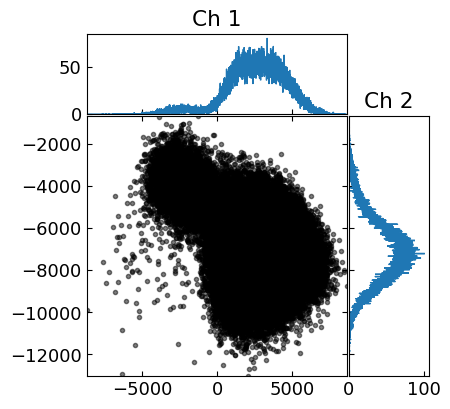

<Figure size 800x800 with 0 Axes>

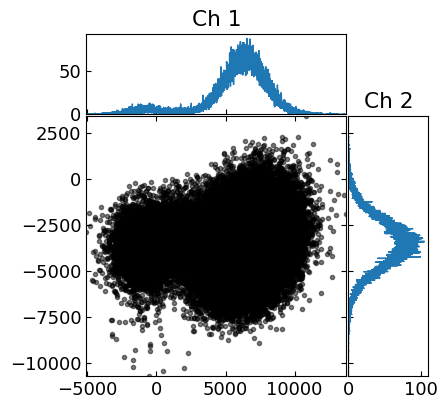

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3


KeyboardInterrupt: 

In [4]:
num_steps = 51
reps = 2000
sweep_time =5000# 50000
swap_freq=-.021
swap_time=213.58765318403013
# check_df, pop_df, values = run_rabi_ef_swap(q1, q2, general_vals_dict,
#                      num_steps, sweep_time,
#                      swap_freq, swap_time, reps)
J_dict , vals_dict = sweep_J(0,1,201, q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_freq, reps)

<Figure size 960x720 with 0 Axes>

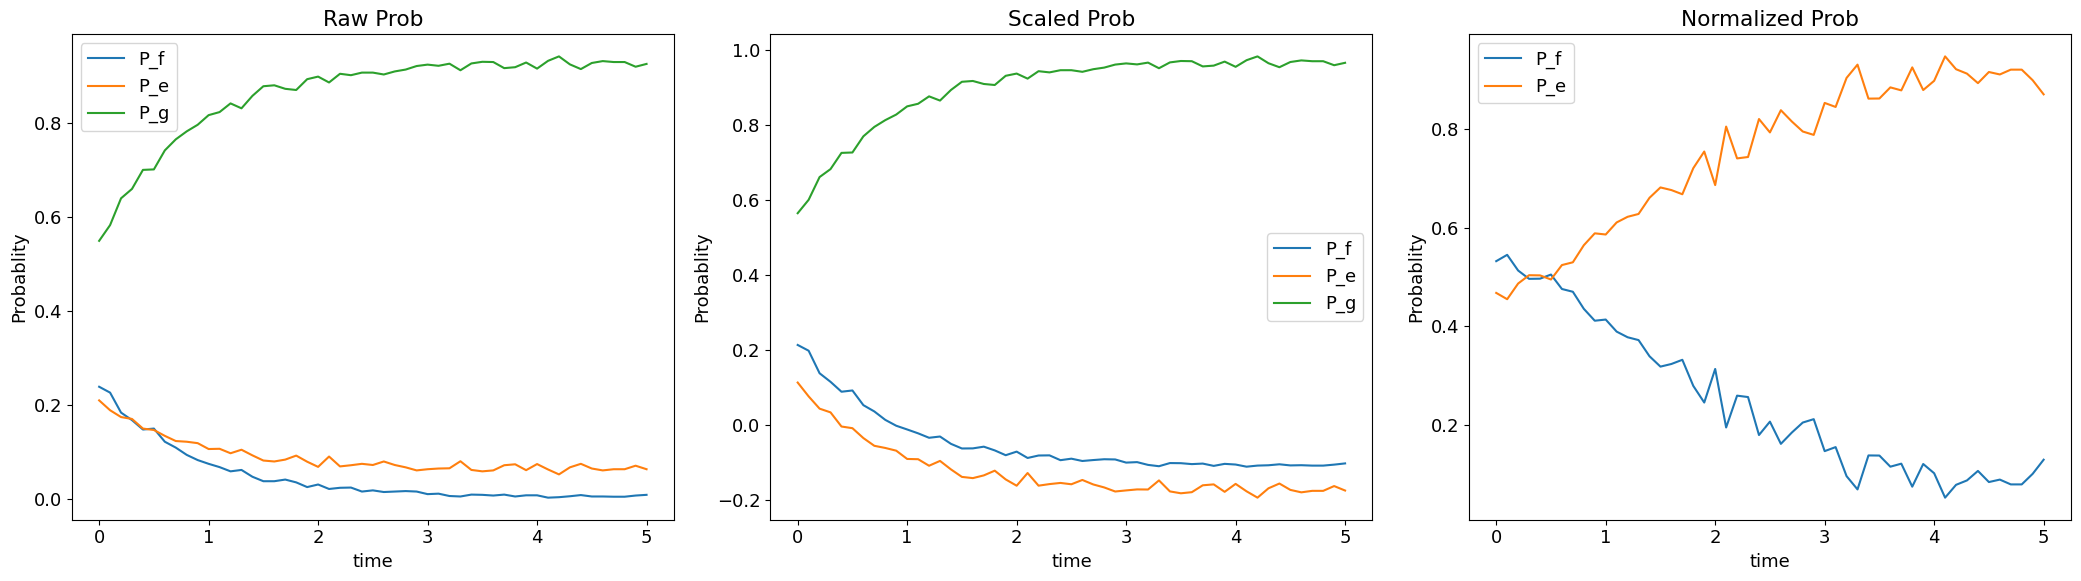

In [7]:
scale_matrix = np.array([[ 1.04489856, -0.02682748, -0.01807108],
       [-0.28202628,  1.35096177, -0.06893549],
       [-0.10815337, -0.2466758 ,  1.35482917]])

measured_pop = np.array([J_dict[0]['P_g'], J_dict[0]['P_e'], J_dict[0]['P_f']])
scaled_p = np.matmul(scale_matrix, measured_pop)
scaled_df = pd.DataFrame({'time': J_dict[0]['time'], 'P_g': scaled_p[0], 'P_e': scaled_p[1], 'P_f': scaled_p[2]})
normalization_val = J_dict[0]['P_f'] + J_dict[0]['P_e']
normalized_df = pd.DataFrame({'time':J_dict[0]['time'], 'P_f':J_dict[0]['P_f']/normalization_val,'P_e':J_dict[0]['P_e']/normalization_val, "P_g":J_dict[0]['P_g']/normalization_val })
keys = ['P_f', 'P_e', "P_g"]
plt.figure(dpi = 150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(
        data=J_dict[0],
        x="time",
        y=key,
        ax=axes[0],
        label = key
    )
    sns.lineplot(
        data=scaled_df,
        x="time",
        y=key,
        ax=axes[1],
        label = key
    )
    if 'P_g' != key:
        sns.lineplot(
            data=normalized_df,
            x="time",
            y=key,
            ax=axes[2],
            label = key
        )
axes[1].set_xlabel("time")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Scaled Prob")
axes[1].legend()
axes[0].set_xlabel("time")
axes[0].set_ylabel("Probablity")
axes[0].set_title("Raw Prob")
axes[0].legend()
axes[2].set_xlabel("time")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Normalized Prob")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()

In [ ]:
# scale_matrix = np.array([[ 1.04489856, -0.02682748, -0.01807108],
#        [-0.28202628,  1.35096177, -0.06893549],
#        [-0.10815337, -0.2466758 ,  1.35482917]])

# measured_pop = np.array([pop_df['Pop_g'], pop_df['Pop_e'], pop_df['Pop_f']])
# scaled_p = np.matmul(scale_matrix, measured_pop)
# scaled_df = pd.DataFrame({'time': check_df['time'], 'P_g': scaled_p[0]/reps, 'P_e': scaled_p[1]/reps, 'P_f': scaled_p[2]/reps})
# normalization_val = check_df['P_f'] + check_df['P_e']
# normalized_df = pd.DataFrame({'time':check_df['time'], 'P_f':check_df['P_f']/normalization_val,'P_e':check_df['P_e']/normalization_val, "P_g":check_df['P_g']/normalization_val })
# keys = ['P_f', 'P_e', "P_g"]
# plt.figure(dpi = 150)
# fig, axes = plt.subplots(1, 3, figsize=(21, 6))
# for key in keys:
#     sns.lineplot(
#         data=check_df,
#         x="time",
#         y=key,
#         ax=axes[0],
#         label = key
#     )
#     sns.lineplot(
#         data=scaled_df,
#         x="time",
#         y=key,
#         ax=axes[1],
#         label = key
#     )
#     if 'P_g' != key:
#         sns.lineplot(
#             data=normalized_df,
#             x="time",
#             y=key,
#             ax=axes[2],
#             label = key
#         )
# axes[1].set_xlabel("time")
# axes[1].set_ylabel("Probablity")
# axes[1].set_title("Scaled Prob")
# axes[1].legend()
# axes[0].set_xlabel("time")
# axes[0].set_ylabel("Probablity")
# axes[0].set_title("Raw Prob")
# axes[0].legend()
# axes[2].set_xlabel("time")
# axes[2].set_ylabel("Probablity")
# axes[2].set_title("Normalized Prob")
# axes[2].legend()
# # Adjust layout for better spacing
# plt.tight_layout()

